# Compute SHAP Values

SHAP values for each predictor were calculated for SVR and RF model families  separately based on how much, on average, each predictor contributes to increasing or decreasing the prediction accuracy, as measured by average RMSE across folds, when included with other predictors. Specifically, the SHAP value for each predictor, $ i $, is computed using the following formula:

\begin{align*}
\phi_i(F, v) &= \frac{1}{|F|!} \sum_{S \subseteq F \setminus \{i\}} |S|! (|F| - |S| - 1)! \big[\nu(S) - \nu(S \cup \{i\}) \big], \\
&= \frac{1}{|F|} \sum_{L = 0}^{|F|-1} \frac{1}{\binom{|F|-1}{L}} \sum_{\substack{S \subseteq F \setminus \{i\} \\ |S| = L}}  \big[\nu(S) - \nu(S \cup \{i\}) \big],
\end{align*}
where $ \phi_i $ is the SHAP function, $ F $ is the set of all predictors (7 in total), $ S $ is any subset of $F$ that does not include predictor $ i $, $ \nu(S) $ is the so-called characteristic function given by the average RMSE score for the model using the subset of predictors $ S $, and $\big[\nu(S) - \nu(S \cup \{i\}) \big]$ is the **marginal contribution** of predictor $ i $ to the subset $ S $. We note that a positive value of $\big[\nu(S) - \nu(S \cup \{i\}) \big]$ would imply that RMSE decreases (prediction accuracy improves) when predictor $i$ is used in conjunction with the predictors in $S$ than otherwise. For $S = \{\}$, the empty set, the best RMSE predictor for any outer test-training fold is the constant predictor equal to the mean value of the outer training fold. SHAP values were computed for each predictor using the following Python script. 


In [15]:
# import necessary python packages
import pandas as pd
import numpy as np
import itertools
import math

# loading Data
model_type = 'SVR'

# Load the CSV file
df = pd.read_csv(f'data.csv')

# Split the 'Data Combination' into a list of features
df['Features'] = df['Data Combination'].astype(str).apply(
    lambda x: x.split() if x != 'Null' else []
)
print(df)

       Data Combination  Mean-RMSE                 Features
0                   PSW  19.539402                    [PSW]
1              RS-trans  23.916031               [RS-trans]
2                   PSG  18.806939                    [PSG]
3                    DM  23.977912                     [DM]
4                    FA  22.115956                     [FA]
..                  ...        ...                      ...
123  DM LV PSG RS-trans  18.954037  [DM, LV, PSG, RS-trans]
124        DM FA PSG RS  16.206378        [DM, FA, PSG, RS]
125  LV PSG RS RS-trans  16.381748  [LV, PSG, RS, RS-trans]
126           FA LV PSW  19.440104            [FA, LV, PSW]
127                Null  22.256337                       []

[128 rows x 3 columns]


In [16]:
# Function to calculate SHAP value
def shap_value(feature, df):
    shap_val = 0
    marginal_contributions = []
    average_shap_vals = [] 
    F = len(set(itertools.chain(*df['Features'])))
    ave_all = 1/ F
    
    for i in range(0,7):
        #find all subset S with size i
        subset_df = df[df['Features'].apply(lambda x: len(x) == i and feature not in x)]
        #print(f"Subset for i = {i}:\n{subset_df}\n")
        marginal_contributions_i = 0
   
        for index, row in subset_df.iterrows():
            current_features = row['Features']
            extended_features = current_features + [feature]
            #find subset {S U feature}
            matched_df = df[df['Features'].apply(lambda x: set(extended_features) == set(x))].iloc[0]
            without_feature_rmse = row['Mean-RMSE']
            with_feature_rmse = matched_df['Mean-RMSE']
            marginal_contribution = without_feature_rmse - with_feature_rmse
            marginal_contributions.append(marginal_contribution)
            marginal_contributions_i+=marginal_contribution
    
            iSize_weight = 1/math.comb(F-1, i)
        ave_iSize_marginal =  marginal_contributions_i * iSize_weight
        average_shap_vals.append(ave_iSize_marginal)
        shap_val += ave_iSize_marginal

    shap_val = shap_val*ave_all
    return shap_val, marginal_contributions, average_shap_vals



# Extract unique features from all rows
features = list(set(itertools.chain(*df['Features'])))
# Calculate SHAP values, marginal contributions, and average marginal contributions for each subset 𝑆 of size 𝑖 for all features
shap_results = {
    feature: {
        "shap_val": shap_value(feature, df)[0],  # Overall SHAP value
        "marginal_contributions": shap_value(feature, df)[1],  # Marginal contributions
        "average_shap_vals": shap_value(feature, df)[2],  # Average SHAP values by subset size
    }
    for feature in features
}
# Extract SHAP values from the results
shap_values = {feature: result["shap_val"] for feature, result in shap_results.items()}
# Sort the SHAP values dictionary by value (descending order)
sorted_shap_values = dict(sorted(shap_values.items(), key=lambda item: item[1], reverse=True))
# Print the sorted SHAP values
print(f"SHAP values for all features {features}:")
for feature, shap_val in sorted_shap_values.items():
    print(f"{feature}: {shap_val}")

# Sort shap_results by feature names (keys) alphabetically
shap_results1 = dict(sorted(shap_results.items(), key=lambda item: item[0]))


SHAP values for all features ['PSW', 'RS', 'LV', 'PSG', 'RS-trans', 'DM', 'FA']:
RS: 3.6507188158193573
PSG: 1.2323246454446033
PSW: 1.0251507303669056
LV: 0.5818898959840372
FA: 0.16066871326295096
DM: -0.13890190551147447
RS-trans: -0.32899770951590085


## Plot Marginal Contribution Values

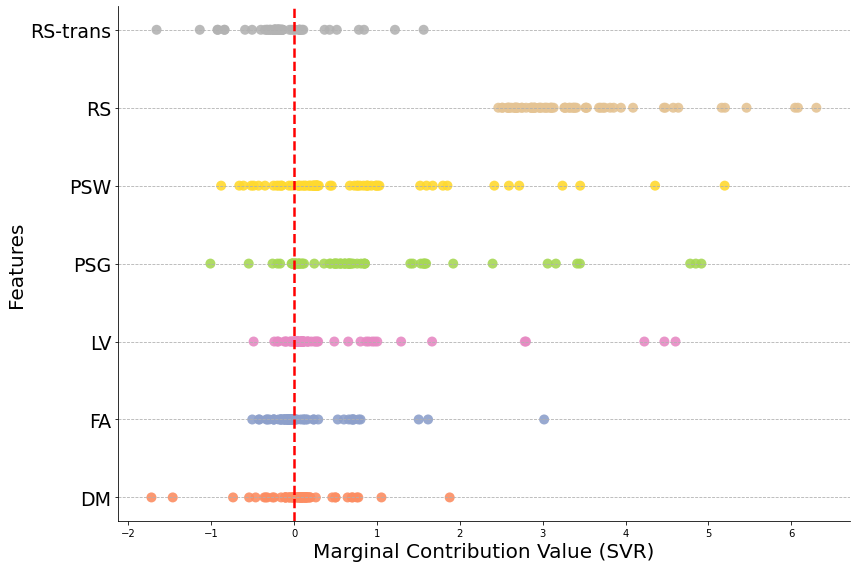

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# Combine marginal contributions and average SHAP values into one dictionary
combined_shap_data = {}

for feature, result in shap_results1.items():

    # Add data to combined dictionary
    combined_shap_data[feature] = {
        "marginal_contributions": result["marginal_contributions"],
        "average_shap_vals": result["average_shap_vals"]
    }

# Create a plot to display both marginal contributions and average SHAP values
plt.figure(figsize=(12, 8))
colors = sns.color_palette("Set2", len(features)+1)
idx = 0
for feature, data in combined_shap_data.items():
    marginal_contributions = data["marginal_contributions"]
    avg_shap_vals = data["average_shap_vals"]

    # Plot marginal contributions
    idx +=1
    plt.scatter(
        marginal_contributions,  # x-axis: Marginal Contributions
        [feature] * len(marginal_contributions),  # y-axis: Features
        label=f"{feature} (Marginal Contributions)",
        alpha=0.9,
        s=100,  # Point size
        edgecolors='none',
        color = colors[idx]
    )
# Add plot details
plt.xlabel(f"Marginal Contribution Value ({model_type})", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.grid(axis='y', linestyle='--')  # Add horizontal gridlines
plt.axvline(x=0, color='red', linestyle='--', linewidth=2.5)  # Add a vertical line at x=0
plt.tick_params(axis='y', labelsize=19)  # Increase font size for y-axis tick labels
plt.gca().spines['top'].set_visible(False)  # Remove top frame
plt.gca().spines['right'].set_visible(False)  # Remove right frame
plt.tight_layout()

# Save the plot
#plt.savefig(f'marginal_contributions_{model_type}.png', dpi=300)

# Show plot
plt.show()